R => Python  
Source: https://web.stanford.edu/class/stats191/notebooks/Bootstrapping_regression.html


NOTE: 
* Not exactly porting R to Python.
* Also not [rpy2](https://rpy2.readthedocs.io/en/version_2.8.x/)

## Model selection

In a given regression situation, there are often many choices to
be made. Recall our usual setup
$$
Y_{n \times 1} = X_{n \times p} \beta_{p \times 1} + \epsilon_{n \times 1}.
$$

Any *subset $A \subset \{1, \dots, p\}$* yields a new regression model
$$
{\cal M}(A): Y_{n \times 1} = X[,A] \beta[A] + \epsilon_{n \times 1}
$$
by setting $\beta[A^c]=0$.

**Model selection** is, roughly speaking, how to choose $A$ among the
$2^p$ possible choices.

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sm.version.version

'0.9.0'

In [3]:
import scipy; scipy.__version__

'0.18.1'

### Election data

Here is a dataset from the book that we will use to explore different model selection approaches.

Variable | Description
--- | ---
$V$ | votes for a presidential candidate
$I$ | are they incumbent?
$D$ | Democrat or Republican incumbent?
$W$ | wartime election?
$G$ | GDP growth rate in election year
$P$ | (absolute) GDP deflator growth rate
$N$ | number of quarters in which GDP growth rate $> 3.2\%$

In [4]:
url = 'http://stats191.stanford.edu/data/election.table'
election_data = pd.read_table(url)
election_data.head()

/home/doojung/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app


,Year,V,I,D,W,G,P,N
0,1916,0.5168,1,1,0,2.229,4.252,3
1,1920,0.3612,1,0,1,-11.463,16.535,5
2,1924,0.4176,-1,-1,0,-3.872,5.161,10
3,1928,0.4118,-1,0,0,4.623,0.183,7
4,1932,0.5916,-1,-1,0,-14.901,7.069,4


In [5]:
# sns.pairplot(election_data)
# plt.show()

## Problem & Goals

* When we have many predictors (with many possible interactions), it can be difficult to find a good model.
* Which main effects do we include?
* Which interactions do we include?
* Model selection procedures try to *simplify / automate* this task.
* Election data has $2^6=64$ different models with just main effects!

## General comments

- This is generally an "unsolved" problem in statistics: there are no magic procedures to get you the "best model."

- Many machine learning methods look for good "sparse" models: selecting a "sparse" model.

- "Machine learning" often work with very many predictors.

- Our model selection problem is generally at a much smaller scale than "data mining" problems.

- Still, it is a hard problem.

- **Inference after selection is full of pitfalls!** 



## Hypothetical example
* Suppose we fit a a model $F: \quad Y_{n \times 1} = X_{n \times p} \beta_{p \times 1} + \varepsilon_{n \times 1}$ with predictors ${ X}_1, \dots, { X}_p$.
* In reality, some of the $\beta$s may be zero. Let's suppose that $\beta_{j+1}= \dots= \beta_{p}=0$.
* Then, any model that includes $\beta_0, \dots, \beta_j$ is *correct*: which model gives the *best* estimates of $\beta_0, \dots, \beta_j$?
* Principle of *parsimony* (i.e. Occam's razor) says that the model with *only* ${X}_1, \dots, {X}_j$ is "best".

## Justifying parsimony

- For simplicity, let's assume that $j=1$ so there is only one coefficient to estimate.
- Then, because each model gives an *unbiased* estimate of $\beta_1$ we can compare models based on $\text{Var}(\widehat{\beta}_1).$
- The best model, in terms of this variance, is the one containing only ${ X}_1$.
- What if we didn't know that only $\beta_1$ was non-zero (which we don't know in general)?
- In this situation, we must choose a set of variables.

## Model selection: choosing a subset of variables

* To "implement" a model selection procedure, we first need a criterion or benchmark to compare two models.
* Given a criterion, we also need a search strategy.
* With a limited number of predictors, it is possible to search all possible models (`leaps` in `R`).

## Candidate criteria

Possible criteria:

* $R^2$: not a good criterion. Always increase with model size $\implies$ "optimum" is to take the biggest model.
* Adjusted $R^2$: better. It "penalized" bigger models. Follows principle of parsimony / Occam's razor.
* Mallow's $C_p$ - attempts to estimate a model's predictive power, i.e. the power to predict a new observation.

### Best subsets, $R^2$

Leaps takes a design matrix as argument: throw away the intercept
column or leaps will complain.


In [6]:
# R leaps: Regression subset selection, including exhaustive search
# Source: https://cran.r-project.org/web/packages/leaps/leaps.pdf

In [7]:
election_data.head()

,Year,V,I,D,W,G,P,N
0,1916,0.5168,1,1,0,2.229,4.252,3
1,1920,0.3612,1,0,1,-11.463,16.535,5
2,1924,0.4176,-1,-1,0,-3.872,5.161,10
3,1928,0.4118,-1,0,0,4.623,0.183,7
4,1932,0.5916,-1,-1,0,-14.901,7.069,4


In [8]:
election_data.columns

Index(['Year  ', 'V  ', 'I  ', 'D  ', 'W  ', 'G  ', 'P  ', 'N  '], dtype='object')

In [9]:
election_data.rename(columns={"Year  ":"Year",
                               "V  ":"V",
                               "I  ":"I",
                               "D  ":"D",
                               "W  ":"W",
                               "G  ":"G",
                               "P  ":"P",
                               "N  ":"N" 
                               }, inplace=True)
election_data.columns

Index(['Year', 'V', 'I', 'D', 'W', 'G', 'P', 'N'], dtype='object')

In [10]:
election_res = ols('V ~ I + D + W + G:I + P + N', data=election_data).fit()
election_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      V   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     8.769
Date:                Fri, 28 Jun 2019   Prob (F-statistic):           0.000435
Time:                        20:58:15   Log-Likelihood:                 41.470
No. Observations:                  21   AIC:                            -68.94
Df Residuals:                      14   BIC:                            -61.63
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5112      0.032     15.875      0.000       0.442       0.580
I             -0.0201      0.017     -1.190      0.254      -0.056       0.016
D              0.0546      0.021      2.655      0.019       0.010       0.099
W              0.0134      0.042      0.317      0.756      -0.077       0.104
G:I            0.0097      0.002      5.471      0.000       0.006       0.013
P             -0.0007      0.004     -0.180      0.859      -0.009       0.008
N             -0.0052      0.004     -1.361      0.195      -0.013       0.003
==============================================================================
Omnibus:                        6.714   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                4.488
Skew:                           1.074   Prob(JB):                        0.106
Kurtosis:                       3.719   Cond. No.                         43.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Could not find the Python equivalent to R package, "leaps"  

Source: https://stackoverflow.com/questions/37624920/subset-regression-in-python-via-exhaustive-search  
Source: https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm

In [11]:
election_res.model.exog_names.remove("Intercept")

In [12]:
election_res.model.exog_names

['I', 'D', 'W', 'G:I', 'P', 'N']

**This is not equivalent to R leaps**

In [13]:
# This is not equivalent to R leaps
from itertools import combinations
scores_lst=[]
for r in range(1, len(election_res.model.exog_names)+1):
    comb = combinations(election_res.model.exog_names, r = r)
    for item in comb:
        formula = 'V ~ {}'.format('+'.join(set(item)))
        
        # method='r2' in the R notebook
        score = ols(formula, election_data).fit().rsquared
        scores_lst.append((len(item)+1, formula, score))

In [14]:
scores_df = pd.DataFrame(scores_lst, columns=["size","formula","score"])
scores_df.head(10)

,size,formula,score
0,2,V ~ I,0.120047
1,2,V ~ D,0.249171
2,2,V ~ W,0.008446
3,2,V ~ G:I,0.612163
4,2,V ~ P,0.110441
5,2,V ~ N,0.021514
6,3,V ~ I+D,0.260595
7,3,V ~ I+W,0.180652
8,3,V ~ G:I+I,0.648134
9,3,V ~ I+P,0.261660


Let's plot the $R^2$ as a function of the model size. We see that the
full model does include all variables. 

In [15]:
scores_df_grpd = scores_df.groupby("size").max()
scores_df_grpd

,formula,score
size,,
2,V ~ W,0.612163
3,V ~ W+D,0.734504
4,V ~ P+W+D,0.765193
5,V ~ N+P+W+D,0.788278
6,V ~ I+D+N+P+W,0.789340
7,V ~ G:I+I+D+N+P+W,0.789828


In [16]:
def plotting_size_vs_score(x, y, annotate=False, ymin=0, ymax=0.85):
    plt.scatter(x, y)
    
    if annotate == True:
        labels = ['{}'.format(round(i, 3)) for i in y]
        for label, x, y in zip(labels, x, y):
            plt.annotate(label, xy=(x, y), alpha=0.5)

    plt.xlabel("size")
    plt.ylabel("r2")
    plt.ylim(ymin, ymax)
    plt.show()

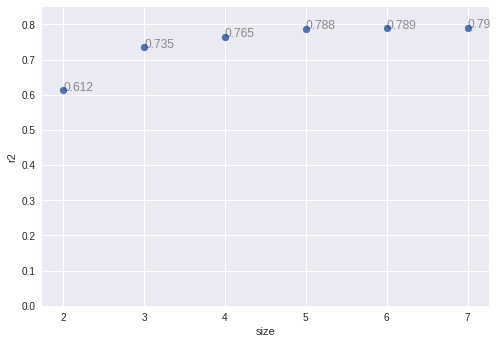

In [17]:
plotting_size_vs_score(scores_df_grpd.index, 
                       scores_df_grpd["score"], 
                       annotate=True)

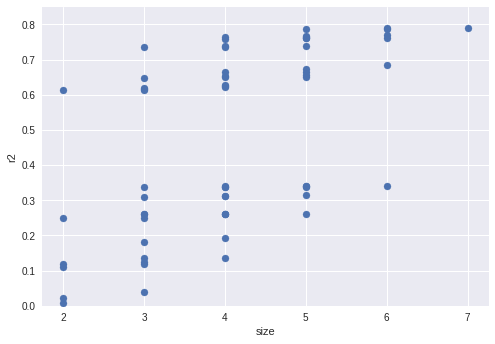

In [18]:
plotting_size_vs_score(scores_df["size"], 
                       scores_df["score"], 
                       annotate=False)

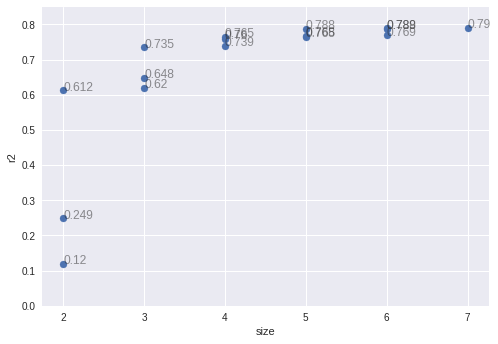

In [19]:
# best 3
best_r2_lst=[]
for i, group in scores_df.groupby("size"):
    best_df = group.sort_values("score", ascending=False)
    best_r2_lst.append(best_df.iloc[:3,:])

# plot them
choose_best_r2_df = pd.concat(best_r2_lst)
plotting_size_vs_score(choose_best_r2_df["size"], 
                       choose_best_r2_df["score"], 
                       annotate=True,
                       ymin=0,
                       ymax=0.85)

**This is not equivalent to R leaps**

## Best subsets, adjusted $R^2$

-   As we add more and more variables to the model - even random ones,
    $R^2$ will increase to 1.

-   Adjusted $R^2$ tries to take this into account by replacing sums of squares by *mean squares*
    $$R^2_a = 1 - \frac{SSE/(n-p-1)}{SST/(n-1)} = 1 - \frac{MSE}{MST}.$$


**This is not equivalent to R leaps**

In [20]:
# This is not equivalent to R leaps
scores_adj_lst=[]
for r in range(1, len(election_res.model.exog_names)+1):
    comb = combinations(election_res.model.exog_names, r = r)
    for item in comb:
        formula = 'V ~ {}'.format('+'.join(set(item)))
        
        # method='adjusted r2' in the R notebook
        score_adj = ols(formula, election_data).fit().rsquared_adj
        scores_adj_lst.append((len(item)+1, formula, score_adj))

In [21]:
scores_adj_df = pd.DataFrame(scores_adj_lst, columns=["size","formula","score_adj"])
scores_adj_df.head(10)

,size,formula,score_adj
0,2,V ~ I,0.073733
1,2,V ~ D,0.209653
2,2,V ~ W,-0.043742
3,2,V ~ G:I,0.591750
4,2,V ~ P,0.063622
5,2,V ~ N,-0.029985
6,3,V ~ I+D,0.178439
7,3,V ~ I+W,0.089613
8,3,V ~ G:I+I,0.609038
9,3,V ~ I+P,0.179622


In [22]:
scores_adj_df_grpd = scores_adj_df.groupby("size").max()
scores_adj_df_grpd

,formula,score_adj
size,,
2,V ~ W,0.591750
3,V ~ W+D,0.705005
4,V ~ P+W+D,0.723757
5,V ~ N+P+W+D,0.735347
6,V ~ I+D+N+P+W,0.719119
7,V ~ G:I+I+D+N+P+W,0.699755


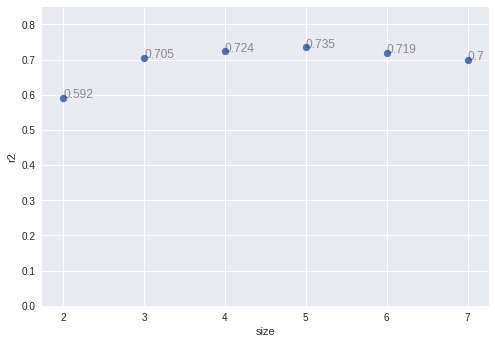

In [23]:
plotting_size_vs_score(scores_adj_df_grpd.index, 
                       scores_adj_df_grpd["score_adj"], 
                       annotate=True)

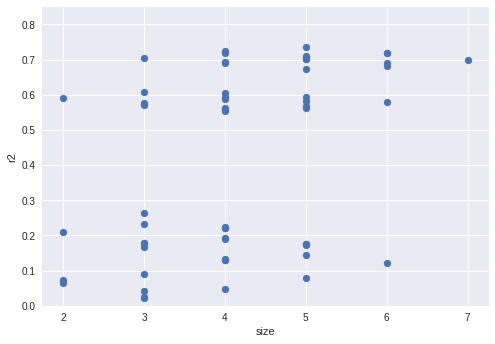

In [24]:
plotting_size_vs_score(scores_adj_df["size"], 
                       scores_adj_df["score_adj"], 
                       annotate=False)

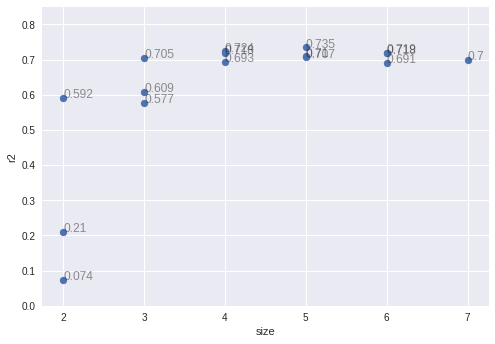

In [25]:
# best 3
best_adj_r2_lst=[]
for i, group in scores_adj_df.groupby("size"):
    best_adj_df = group.sort_values("score_adj", ascending=False)
    best_adj_r2_lst.append(best_adj_df.iloc[:3,:])

# plot them
choose_best_adj_r2_df = pd.concat(best_adj_r2_lst)
plotting_size_vs_score(choose_best_adj_r2_df["size"], 
                       choose_best_adj_r2_df["score_adj"], 
                       annotate=True,
                       ymin=0,
                       ymax=0.85)

In [26]:
# adjust R squared take account of the phenomenon of the R2 
# automatically and spuriously increasing when extra explanatory variables 
# are added to the model.
pd.concat([scores_df[scores_df["size"] == 7], 
           scores_adj_df[scores_adj_df["size"] == 7]],
         axis=1,
         sort=False)

,size,formula,score,size,formula,score_adj
62,7,V ~ G:I+I+D+N+P+W,0.789828,7,V ~ G:I+I+D+N+P+W,0.699755


In [27]:
pd.concat([scores_df[scores_df["size"] == 6], 
           scores_adj_df[scores_adj_df["size"] == 6]],
         axis=1,
         sort=False)

,size,formula,score,size,formula,score_adj
56,6,V ~ G:I+I+D+P+W,0.762030,6,V ~ G:I+I+D+P+W,0.682707
57,6,V ~ G:I+I+D+N+W,0.789340,6,V ~ G:I+I+D+N+W,0.719119
58,6,V ~ I+D+N+P+W,0.340481,6,V ~ I+D+N+P+W,0.120642
59,6,V ~ G:I+I+D+N+P,0.788321,6,V ~ G:I+I+D+N+P,0.717762
60,6,V ~ G:I+I+N+P+W,0.684002,6,V ~ G:I+I+N+P+W,0.578669
61,6,V ~ G:I+D+N+P+W,0.768571,6,V ~ G:I+D+N+P+W,0.691428


### Mallow's $C_p$

- $C_p({\cal M}) = \frac{SSE({\cal M})}{\widehat{\sigma}^2} + 2 \cdot p({\cal M}) - n.$
- $\widehat{\sigma}^2=SSE(F)/df_F$ is the "best" estimate of $\sigma^2$ we have (use the fullest model), i.e. in the election data it uses all 6 main effects.
- $SSE({\cal M})$ is the $SSE$ of the model ${\cal M}$.
- $p({\cal M})$ is the number of predictors in ${\cal M}$.
- This is an estimate of the expected mean-squared error of $\widehat{Y}({\cal M})$, it takes *bias* and *variance* into account.

If P regressors are selected from a set of K > P, the Cp statistic for that particular set of regressors is defined as:

C_p = (SSE_p/S2) - n + 2p

where:

    * SSE_k: the error sum of squares for the model with P regressors, where $y_pi$ is the predicted value of the ith observation of Y from the p regressors
    
$$
SSE_p = \sum_{i=1}^n (Y_i - Y_{pi})^2.
$$

    * S2: the residual mean square after regression on the complete set of K regressors and can be estimated by mean square error MSE
    
    * n: number of observations
    
    * p: number of subset explanatory variables
    
Source: https://en.wikipedia.org/wiki/Mallows%27s_Cp
Source: https://pypi.org/project/RegscorePy/

**This is not equivalent to R leaps**

In [28]:
# heavily borrowed from the Source: https://pypi.org/project/RegscorePy/
def calc_mallow_cp(y, y_pred, y_sub, k, p):
    """    
    C_p = (SSE_p/MSE) - (n - 2p)
    """
    n = len(y)
    SSE_p = np.sum((y - y_sub)**2)
    MSE = np.sum((y - y_pred)**2)/(n - k)
    return (SSE_p / MSE) - (n - 2 * p)

In [29]:
# This is not equivalent to R leaps
scores_cp_lst=[]
for r in range(1, len(election_res.model.exog_names)+1):
    comb = combinations(election_res.model.exog_names, r = r)
    
    # y
    y = election_data["V"]
    
    # full model
    formula_full = 'V ~ I + D + W + G:I + P + N'
    election_res_full = ols(formula_full, data=election_data).fit()
    y_pred = election_res_full.predict()    
    
    for item in comb:
        
        # method='cp' in the R notebook
        formula_subset = 'V ~ {}'.format('+'.join(set(item)))        
        
        # y_sub
        election_res_sub = ols(formula_subset, election_data).fit()
        y_sub = election_res_sub.predict()
        
        # mallow's cp
        cp = calc_mallow_cp(y, y_pred, y_sub, k=6, p=len(set(item)))
        scores_cp_lst.append((len(item)+1, formula, cp))

In [30]:
scores_cp_df = pd.DataFrame(scores_cp_lst, 
                            columns=["size","formula","Cp"])
scores_cp_df.head(10)

,size,formula,Cp
0,2,V ~ G:I+I+D+N+P+W,43.802434
1,2,V ~ G:I+I+D+N+P+W,34.586822
2,2,V ~ G:I+I+D+N+P+W,51.767416
3,2,V ~ G:I+I+D+N+P+W,8.680026
4,2,V ~ G:I+I+D+N+P+W,44.487956
5,2,V ~ G:I+I+D+N+P+W,50.834693
6,3,V ~ G:I+I+D+N+P+W,35.771487
7,3,V ~ G:I+I+D+N+P+W,41.477029
8,3,V ~ G:I+I+D+N+P+W,8.112744
9,3,V ~ G:I+I+D+N+P+W,35.695478


In [31]:
scores_cp_df_grpd = scores_cp_df.groupby("size").min()
scores_cp_df_grpd

,formula,Cp
size,,
2,V ~ G:I+I+D+N+P+W,8.680026
3,V ~ G:I+I+D+N+P+W,1.948472
4,V ~ G:I+I+D+N+P+W,1.758198
5,V ~ G:I+I+D+N+P+W,2.110640
6,V ~ G:I+I+D+N+P+W,4.034870
7,V ~ G:I+I+D+N+P+W,6.000000


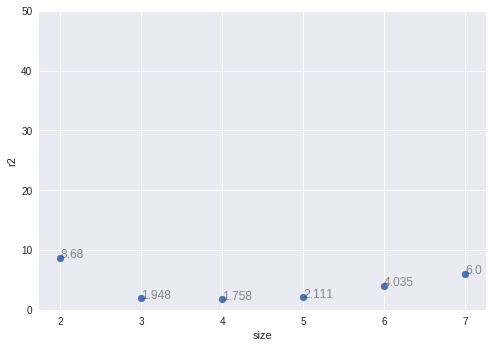

In [32]:
plotting_size_vs_score(scores_cp_df_grpd.index, 
                       scores_cp_df_grpd["Cp"], 
                       annotate=True,
                       ymin=0,
                       ymax=50)

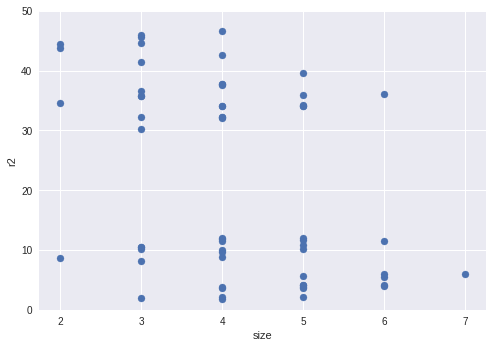

In [33]:
plotting_size_vs_score(scores_cp_df["size"], 
                       scores_cp_df["Cp"], 
                       annotate=False,
                       ymin=0,
                       ymax=50)

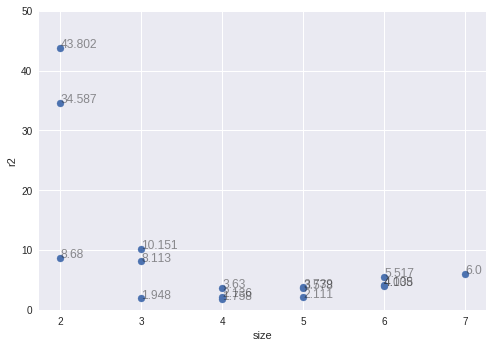

In [34]:
# best 3
best_cp_lst=[]
for i, group in scores_cp_df.groupby("size"):
    best_df = group.sort_values("Cp")
    best_cp_lst.append(best_df.iloc[:3,:])

# plot them
choose_best_cp_df = pd.concat(best_cp_lst)
plotting_size_vs_score(choose_best_cp_df["size"], 
                       choose_best_cp_df["Cp"], 
                       annotate=True,
                       ymin=0,
                       ymax=50)